# Applied Mathematics 115: Mathematical Modeling  
---
*2024 Spring / Full Term*

**Meeting Time:**  
Tuesday 10:30 AM - 11:45 AM  
Thursday 10:30 AM - 11:45 AM
<br>
<br>

**Instructors:**  
*Michael P. Brenner* (Pierce Hall 313) brenner@seas.harvard.edu  
Francesco Mottes fmottes@seas.harvard.edu  

**Teaching Fellows:**  
Henry Bae henrybae@college.harvard.edu  
Sarah Martinson sarahmartinson@g.harvard.edu  
Shruti Sharma ssharma1@g.harvard.edu  
Al Shodiev alshodiev@college.harvard.edu  
Alex Sullivan alexsullivan@college.harvard.edu  
Matt Tibbitts mtibbitts@college.harvard.edu  


# Lecture 6 Advanced: Racing

This notebook discusses an approach to solving the Keller problem we discussed in class that is an advanced notebook for those who wish to study it. This is not required and the homework problem associated with it is for **extra credit**.  

The first part of the notebook gives an introduction to solving optimization problems for solutions of ODEs in JAX, a modern Machine Learning library with native automatic differentiation.

The second part of the notebook uses JAX to solve the Keller problem.

In [8]:
# import numpy as np

import jax
import jax.numpy as np
from jax import jit, grad

# throw error if nans are encountered
jax.config.update('jax_debug_nans', True)

#enable 64-bit precision
jax.config.update("jax_enable_x64", True)

from tqdm import trange
import matplotlib.pyplot as plt

# Solving and fitting ODE's in JAX

Consider the following inverse problem: **given data points of $y(x)$, find the parameters of an ODE $\dot{y}(x)=f(x, y)$.**

Fortunately, using `jax.experimental.ode.odeint`, we can


1.   Integrate an ODE
2.   Compare the integrated solution and real data through loss
3.   Take derivatives of the loss w.r.t. ODE parameters or initial conditions (gradient flows through an integrator)
4.   Optimize parameters or initial conditions using gradient descent.

to solve the inverse problem.

In [9]:
from jax.experimental.ode import odeint   # import JAX's differentiable odeint

## Finding acceleration and initial condition of Newton's law

In this example, the groud truth trajectory is obtained by solving $\dot{y}(t) = 2t$ with an initial condition $y(0) = 0$.

In [3]:
# define ode
def Newton(y, t, a):
    dydt = a*t
    return dydt
# Newton_odeint = odeint(Newton, y, t)

# setup: I.C., ode parameter and t coordinates
y0_real = np.array([0.])  # JAX's odeint expects jax.np.array
a_real = np.array([2.])
t = np.arange(10.)
print("The real acceleration of the object is:", a_real[0])
print("The object starts at y0=",y0_real[0])

# integrate
traj_true = odeint(Newton, y0_real, t, a_real)

The real acceleration of the object is: 2.0
The object starts at y0= 0.0


In [4]:
traj_true

Array([[ 0.       ],
       [ 1.       ],
       [ 3.9999993],
       [ 8.999999 ],
       [15.999997 ],
       [25.       ],
       [36.000008 ],
       [49.       ],
       [63.999996 ],
       [80.99998  ]], dtype=float32)

### Loss and optimization

In [5]:
# MSE loss over trajectory
def loss(a, y0):
    return np.sum((odeint(Newton, y0, t, a).reshape(-1)-traj_true.reshape(-1))**2)

# gradient functions w.r.t. a and y0
dfda = jit(grad(loss, 0))
dfdy0 = jit(grad(loss, 1))

# Guessing y0 and a
y0 = np.array([-0.5])
a = np.array([3.])
print("The initially guessed acceleration is:", a[0])
print("The initially guessed y0 is:", y0[0])

# learning rates
lr_a = 0.00025
lr_y0 = 0.03

# optimization
while np.abs(dfda(a,y0)) > 1e-3 or np.abs(dfdy0(a,y0)) > 1e-3:
    a -= lr_a * dfda(a,y0)
    y0 -= lr_y0 * dfdy0(a,y0)
print("The finally guessed acceleration is:", a[0])
print("The finally guessed y0 is:", y0[0])

The initially guessed acceleration is: 3.0
The initially guessed y0 is: -0.5
The finally guessed acceleration is: 1.9999998
The finally guessed y0 is: -1.7016126e-06


Optimized parameter and initial condition match the real values.

## Finding parameters of a pendulum with friction

The second order differential equation for the angle $\theta$ of a pendulum with friction is,

$$ \ddot{\theta}(t) + b\dot{\theta}(t) + c\sin\theta(t)=0$$

To solve the equation of motion numerically, we break it up into a system of two ODEs by introducing the angular velocity $\omega(t)$ to obtain,

$$
\begin{align*}
 \dot{\theta}(t) &= \omega(t) \\
 \dot{\omega}(t) &= -b\omega(t) - c\sin\theta(t)
\end{align*}
$$

In this example, the ground truth trajectories of $\theta$ and $\omega$ are generated using an initial condition of $\theta(0)=\pi-1$ and $\omega(0) = 0$, and parameters $b=0.25$ and $c=5$.

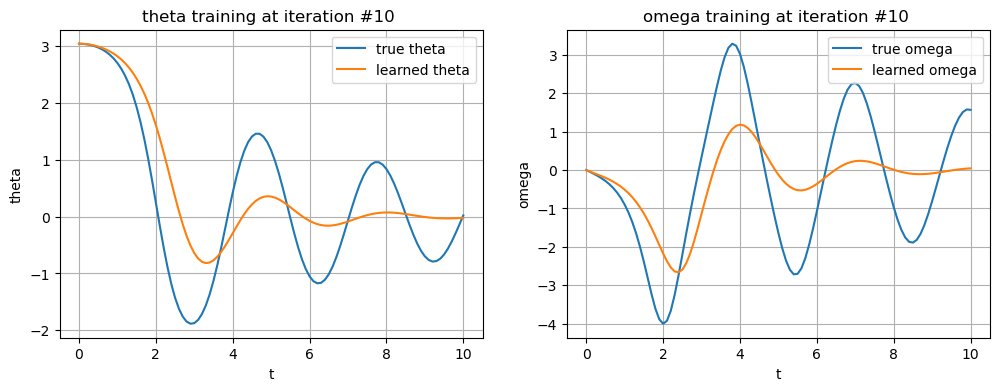

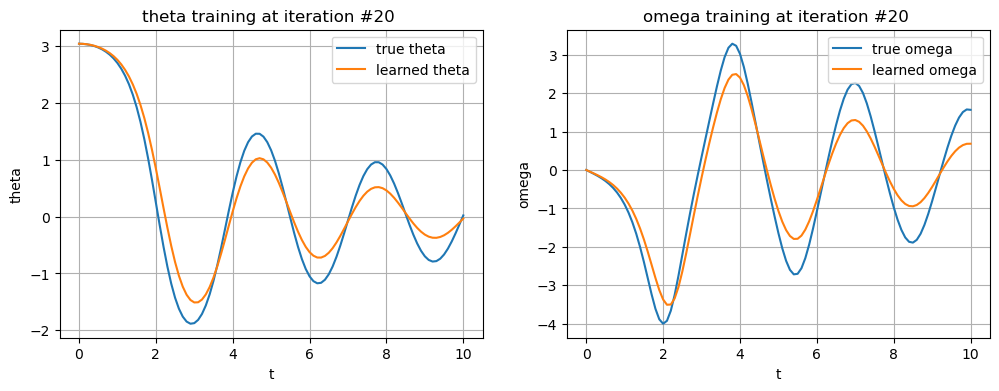

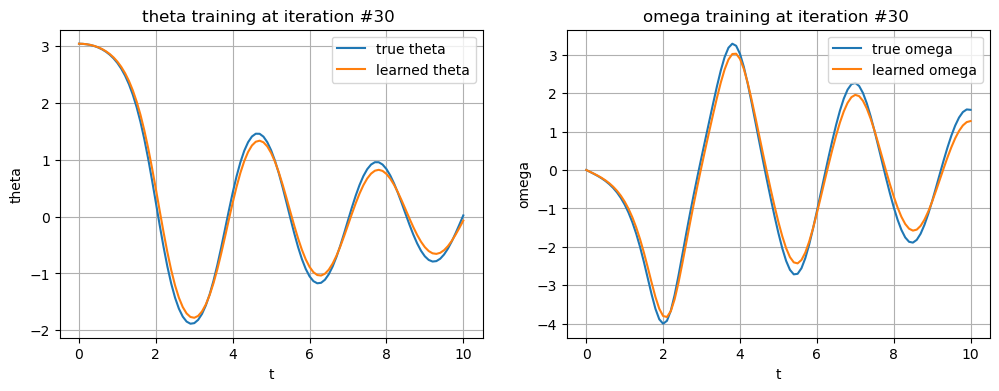

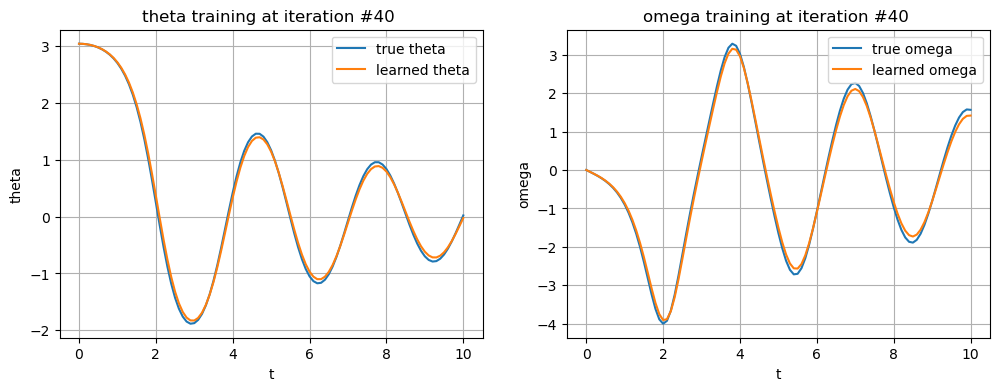

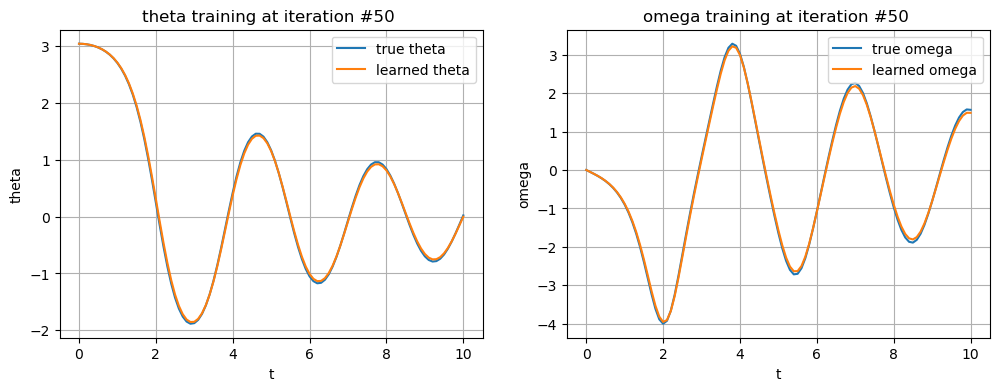

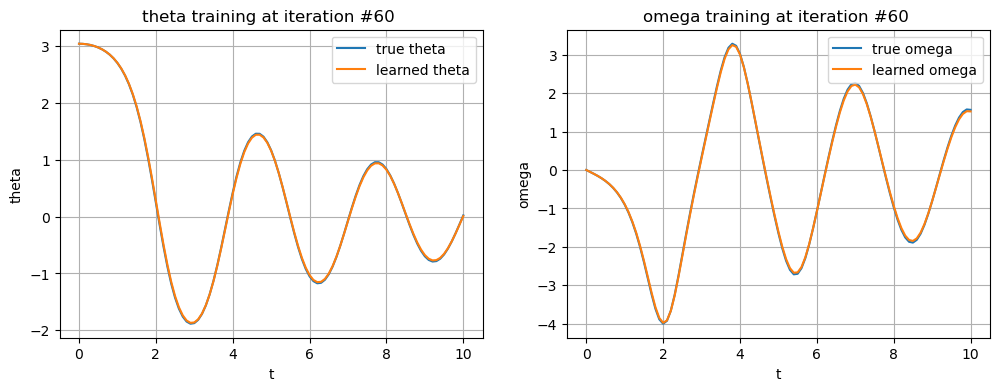

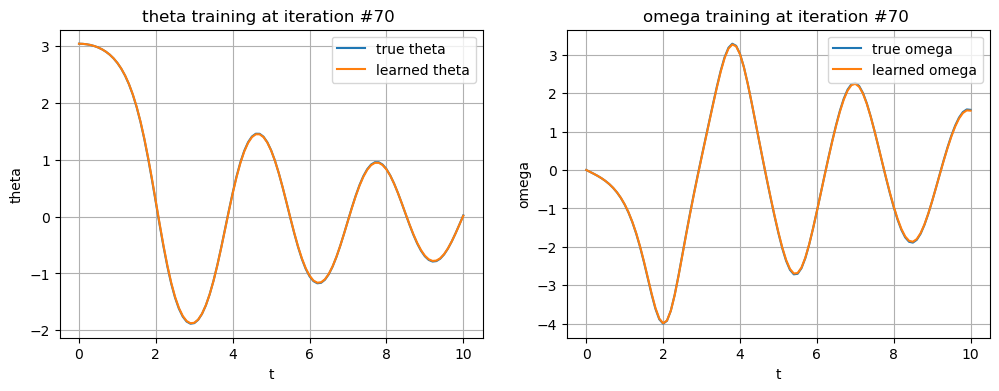

training ended at 77 iteration
learned b: 0.251966267824173 	 true b: 0.25
learned c: 4.990047454833984 	 true c: 5.0


In [6]:
## Pendulum
'''
theta''(t) + b*theta'(t) + c*sin(theta(t)) = 0
theta'(t) = omega(t)
omega'(t) = -b*omega(t) - c*sin(theta(t))
'''

def pendulum(y, t, b, c):
    theta, omega = y
    dydt = np.array([omega, -b*omega - c*np.sin(theta)])
    return dydt
#built = build_odeint(pendulum)

# generate ground truth trajectory
y0 = np.array((np.pi - 0.1, 0.0)) # I.C.
t = np.linspace(0., 10., 101)
b = 0.25
c = 5.0
true_traj = odeint(pendulum, y0, t, b, c)
# above this line=evil math professor

# find parameter b and c with JAX
b_guess = 1.5
c_guess = 4.


def loss(b, c):
    return np.sum((odeint(pendulum, y0, t, b, c) - true_traj)**2)
#odeint(Newton, y0, t, a).reshape(-1)
grad_b = jit(grad(loss, 0))
grad_c = jit(grad(loss, 1))



learning_rate = 0.0002
epochs = 1000  #
tol = 1e-2
for epoch in range(epochs):
    b_guess -= learning_rate * grad_b(b_guess,c_guess)
    c_guess -= learning_rate * grad_c(b_guess,c_guess)

    # check how learned ODE fares aginst the real trajectory
    if (epoch+1) % 10 == 0:
        cur_traj = odeint(pendulum, y0, t, b_guess, c_guess)
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        for i, variable in enumerate(['theta', 'omega']):
            ax[i].plot(t, true_traj[:, i], label=f'true {variable}')
            ax[i].plot(t, cur_traj[:, i], label=f'learned {variable}')
            ax[i].set_xlabel('t')
            ax[i].set_ylabel(f'{variable}')
            ax[i].set_title(f'{variable} training at iteration #{epoch+1} ')
            ax[i].grid()
            ax[i].legend()
        plt.show()

    # break condition
    if np.abs(b-b_guess) < tol and np.abs(c-c_guess) < tol:
        print(f'training ended at {epoch+1} iteration')
        print(f'learned b: {b_guess} \t true b: {b}')
        print(f'learned c: {c_guess} \t true c: {c}')
        break

Voila! The integrated trajectories converge toward the ground truth trajectories as training proresses.

## Lorenz Equations

Can we find the parameters of a chaotic system?

learned rho: 15.791385650634766 	 true b: 28
learned sigma: 8.924689292907715 	 true c: 10


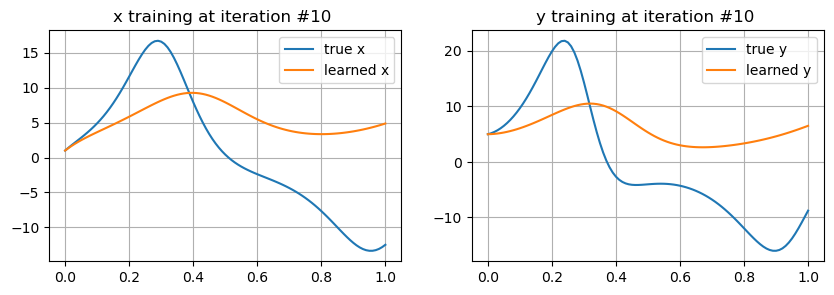

learned rho: 20.807008743286133 	 true b: 28
learned sigma: 9.725375175476074 	 true c: 10


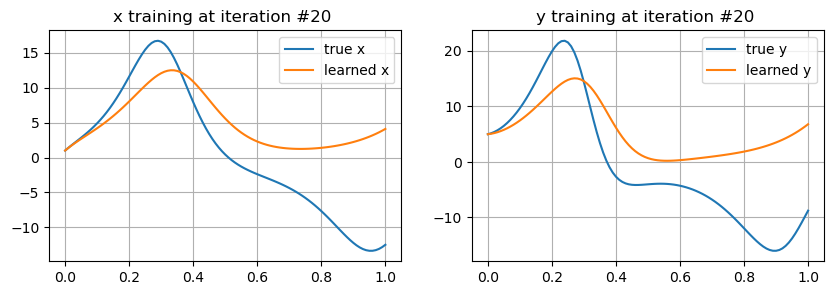

learned rho: 27.458707809448242 	 true b: 28
learned sigma: 10.79084587097168 	 true c: 10


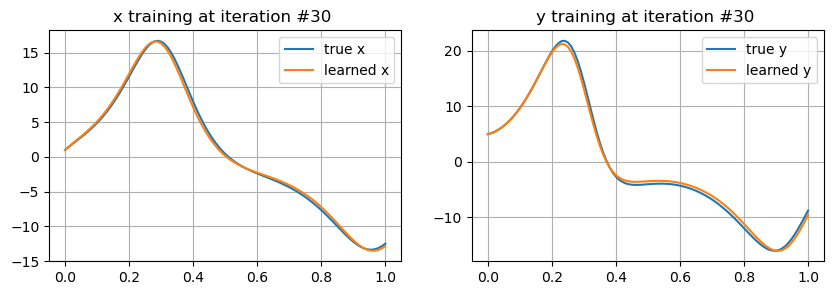

learned rho: 27.769439697265625 	 true b: 28
learned sigma: 10.58090877532959 	 true c: 10


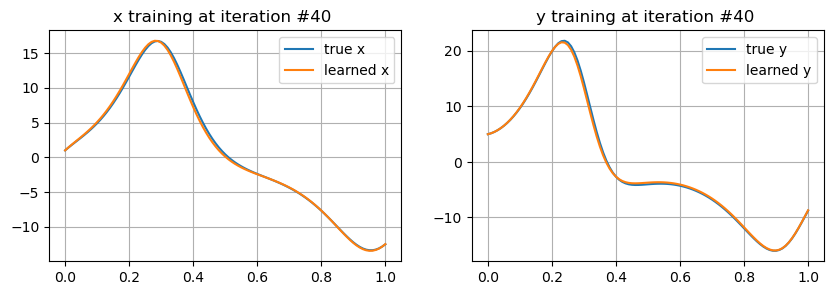

learned rho: 27.837915420532227 	 true b: 28
learned sigma: 10.398330688476562 	 true c: 10


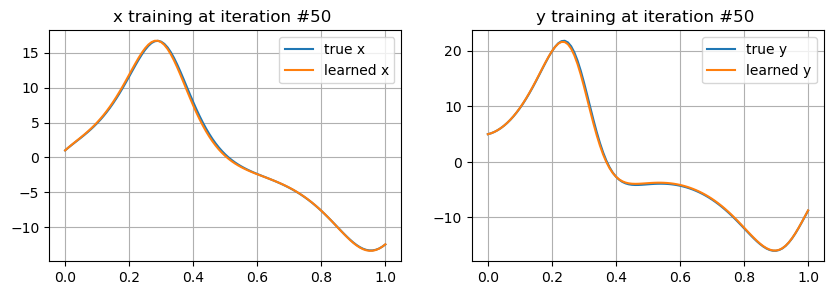

learned rho: 27.886594772338867 	 true b: 28
learned sigma: 10.27078628540039 	 true c: 10


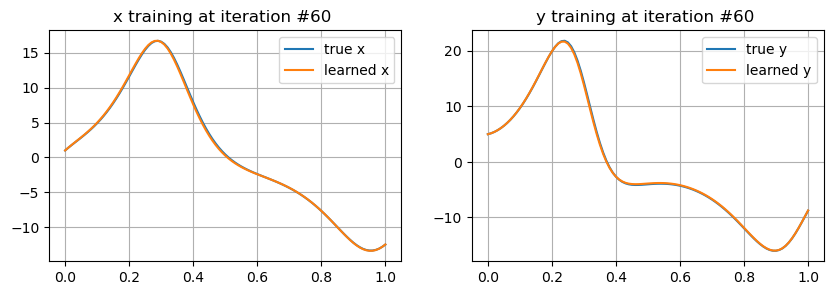

learned rho: 27.921716690063477 	 true b: 28
learned sigma: 10.18316650390625 	 true c: 10


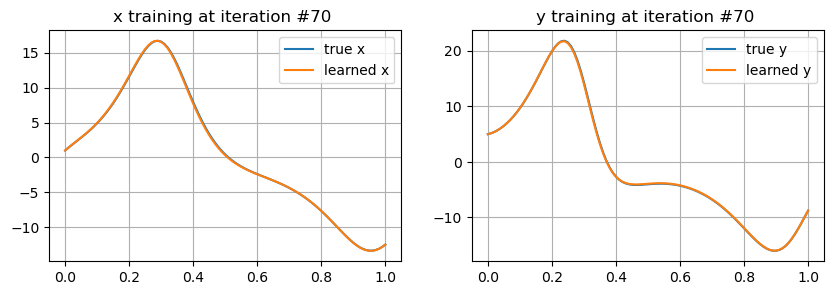

learned rho: 27.946481704711914 	 true b: 28
learned sigma: 10.123485565185547 	 true c: 10


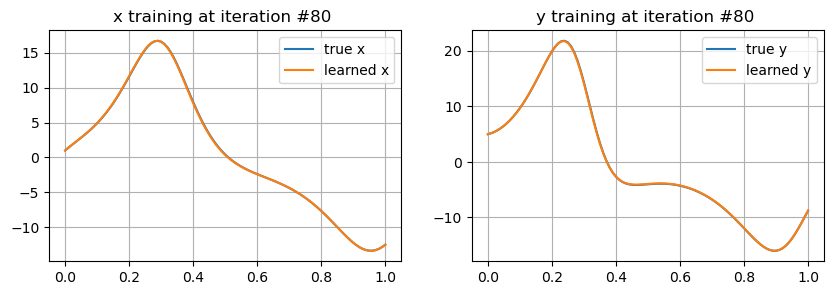

training ended at 86 iteration
learned rho: 27.957544326782227 	 true b: 28
learned sigma: 10.097363471984863 	 true c: 10


In [7]:
## Lorenz Equations

'''
dx/dt = sigma(y-x)
dy/dt = x(rho - z) - y
dz/dt = xy - beta z
sigma=10, beta = 8/3, rho=28 typical parameters
'''

def lorenz(y_full, t, rho,sigma):
    x,y,z= y_full

    beta=8/3.
    dydt = np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z])
    return dydt


# generate ground truth trajectory
y0 = np.array((1.0, 5.0,10.0)) # I.C.
t = np.linspace(0., 1., 101)
rho=28
sigma=10
true_traj = odeint(lorenz, y0, t, rho,sigma)



# find parameter b and c with JAX
rho_guess = 10.
sigma_guess = 8.


def residual(rho, sigma):
    return np.sum((odeint(lorenz,y0, t, rho, sigma) - true_traj)**2)


grad_rho = jit(grad(residual, 0))
grad_sigma = jit(grad(residual, 1))

learning_rate = 0.0002
epochs = 100  #
tol = 1e-1
for epoch in range(epochs):
    rho_guess -= learning_rate * grad_rho(rho_guess,sigma_guess)
    sigma_guess -= learning_rate * grad_sigma(rho_guess,sigma_guess)

    # check how learned ODE fares aginst the real trajectory
    if (epoch+1) % 10 == 0:
        cur_traj = odeint(lorenz, y0, t, rho_guess, sigma_guess)
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        print(f'learned rho: {rho_guess} \t true b: {rho}')
        print(f'learned sigma: {sigma_guess} \t true c: {sigma}')
        for i, variable in enumerate(['x', 'y']):
            ax[i].plot(t, true_traj[:, i], label=f'true {variable}')
            ax[i].plot(t, cur_traj[:, i], label=f'learned {variable}')
            ax[i].set_title(f'{variable} training at iteration #{epoch+1} ')
            ax[i].grid()
            ax[i].legend()
        plt.show()

    # break condition
    if np.abs(rho-rho_guess) < tol and np.abs(sigma-sigma_guess) < tol:
        print(f'training ended at {epoch+1} iteration')
        print(f'learned rho: {rho_guess} \t true b: {rho}')
        print(f'learned sigma: {sigma_guess} \t true c: {sigma}')
        break

# Optimization of Keller's running model 

This part is based on Keller's model of optimal racing strategy. In stead of using dynamic programming to solve the optimization problem we will use gradient descent as in the simpler previous examples.

Three main things to notice:
- We have to introduce an explicit parametrization for P(t) for this method to work (we are trying to learn the parameters of P(t) after all).
- Inequality constraints must be included in the loss as very high penalties. While this often work in practice, it is important to notice that it's not mathematically equivalent to enforcing hard constraints as in the original model.
- In this case we have to normalize the gradients in order for the optimization to work correctly, otherwise we rapidly incur in exploding/vanishing gradient problems. This is just an optimization "trick" and does not derive from any formal mathematical consideration.

## Simulation Setup

In [12]:
from collections import namedtuple

# Model parameters
P_max = 12.0 # m/s^2
k = 1.1 # 1/s
E0 = 2400.0 # m^2/s^2 or J/kg
sigma = 40.0 # m^2/s^3 or W/kg

#container for fixed physiology parameters
PhysiologyParams = namedtuple('PhysiologyParams', ['P_max','k','E0','sigma'])
phys_params = PhysiologyParams(P_max,k,E0,sigma)

In [167]:
def simulate_keller_dx(istate, P_func, P_params, phys_params, dx=.1, L=100.):
    '''
    Integrates Keller model with space discretization.
    '''

    def keller_dx(state, x):

        t,v,E = state

        Px = P_func(x, P_params) #control signal

        dtdx = 1/v
        dvdx = Px / v - phys_params.k
        dEdx = phys_params.sigma / v - Px

        return np.asarray([dtdx, dvdx, dEdx])


    #discretize space
    xs = np.arange(0,L,dx)

    # integrate system of ODEs
    state_x = odeint(keller_dx, istate, xs)

    # compute history of control signal P
    P = jax.vmap(P_func, in_axes=[0,None])(xs, P_params)

    return state_x, P

In [265]:
import numpy as onp # use only for random number generation

## NOTE: JAX can be used too but it works in a very differnt way
# key = random.PRNGKey(0)
# key, subkey = random.split(key)
# random_gaussian = jax.random.normal(subkey)



def neural_net_P(P_max, n_units=10):

    # initialize parameters
    P_params = onp.random.normal(size=(2,n_units+1), scale=.1)

    def P(t, P_params):
        hidden = jax.nn.tanh(P_params[0,0] + P_params[0,1:] * t)
        P = P_max * jax.nn.sigmoid(P_params[1,0] + np.sum(P_params[1,1:] * hidden))
        return P

    return np.asarray(P_params), P


# NUMERICALLY UNSTABLE PARAMETERIZATION
# def polynomial_P(P_max, deg=4):

#     n_terms = int(deg+1)

#     P_params = onp.random.normal(size=n_terms, scale=.1)

#     def P(t, P_params):
#         t_pow = t ** np.arange(n_terms)
#         P = P_max * jax.nn.sigmoid(P_params @ t_pow)
#         return P

#     return np.asarray(P_params), P

## Loss

In [266]:
def loss_time(P_params, init_state, P_func, phys_params, dx=.1, L=100, lambda_Emin=3., lambda_Emax=3.):

    init_state = np.asarray(init_state)

    # simulate Keller model
    state_x, _ = simulate_keller_dx(init_state, P_func, P_params, phys_params, dx, L)

    Ex = state_x[:,2]

    # E violates E > 0
    Emin = np.where(Ex > 0, 0, -Ex).sum()

    # E violates E < E0 (with small tolerance)
    Emax = np.where(Ex < phys_params.E0+1, 0, (Ex-phys_params.E0)).sum()

    # final time
    T = state_x[-1,0]


    return T + lambda_Emin*Emin + lambda_Emax*Emax

## Basic Gradient Descent (not so good)

We use here a basic handmade implementation of gradient descent. It works decently but as we will see more sophisticated algorithms (like Adam) often ensure faster convergence to better solutions.

In [267]:
# P_params, P_func = polynomial_P(phys_params.P_max, deg=5)
P_params, P_func = neural_net_P(phys_params.P_max, n_units=5)

# start with small initial velocity and initial time
# (avoid division by zero in the ODE)
init_state = np.asarray([.001, .001, phys_params.E0])

print(init_state)

[1.0e-03 1.0e-03 2.4e+03]


In [268]:
L = 100. # length of the track
dx = .1 # discretization step of space

# training parameters
EPOCHS = 3000
LEARNING_RATE = 1e-3


# set up optimizer
opt_params = P_params.copy()

# compiled loss and gradient calculation
loss_and_grad = jax.jit(jax.value_and_grad(loss_time), static_argnums=(1,2,3,4,5))

#static arguments must be hashable types (cannot be JAX arrays)
istate = tuple(init_state.tolist())

loss, loss_grad = loss_and_grad(opt_params, istate, P_func, phys_params, L=L, dx=dx)
loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum()) # normalize gradient (might help with convergence)

losses = [float(loss)]
params = [opt_params]

pbar = trange(EPOCHS)
for e in pbar:

    # update parameters
    opt_params = opt_params - LEARNING_RATE * loss_grad


    loss, loss_grad = loss_and_grad(opt_params, istate, P_func, phys_params, L=L, dx=dx)
    loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum()) # normalize gradient


    losses += [float(loss)]
    params += [opt_params]

    pbar.set_description(f'Loss:\t{loss:.2f}')

Loss:	321.71: 100%|██████████| 3000/3000 [00:12<00:00, 249.95it/s]  


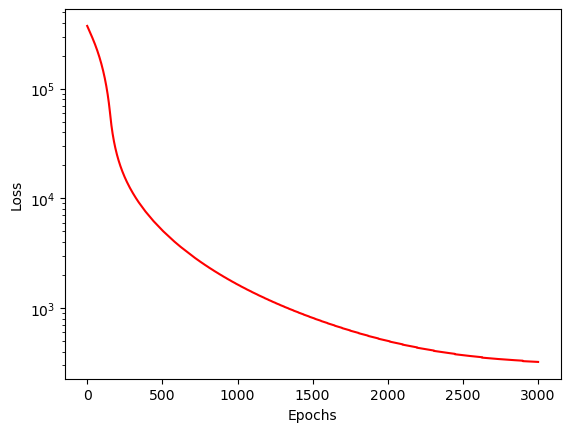

In [269]:
plt.plot(losses,'r')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss');

In [271]:
state_x, P_x = simulate_keller_dx(init_state, P_func, opt_params, phys_params, dx=dx, L=L)

# unpack state for easier plotting
ts = state_x[:,0]
vs = state_x[:,1]
Es = state_x[:,2]

xs = np.arange(0,L,dx)

T = ts[-1]

print(f'Final time in {int(L)}m:\t{float(T):.2f} s')
print(f'Average speed:\t\t{L/float(T):.2f} m/s')

Final time in 100m:	10.16 s
Average speed:		9.84 m/s


**NOTE:** We get a decent total time, but with a lot of energy boundaries violations!! The found solution is therefore infeasible.

## Adam (optax library)

We will use the pre-implemented version of the famous Adam algorithm from the `optax` library.

In [272]:
import optax

In [273]:
# P_params, P_func = polynomial_P(phys_params.P_max, deg=5)
P_params, P_func = neural_net_P(phys_params.P_max, n_units=5)


init_state = np.asarray([.001, .001, phys_params.E0])

print(init_state)

[1.0e-03 1.0e-03 2.4e+03]


In [274]:
L = 100.
dx = .1

EPOCHS = 3000
LEARNING_RATE = 1e-3


# set up optimizer
opt_params = P_params.copy()
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(opt_params)

# compiled loss and gradient calculation
loss_and_grad = jax.jit(jax.value_and_grad(loss_time), static_argnums=(1,2,3,4,5))

#static arguments must be hashable types (cannot be JAX arrays)
istate = tuple(init_state.tolist())

loss, loss_grad = loss_and_grad(opt_params, istate, P_func, phys_params, L=L, dx=dx)
loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum()) # normalize gradient (might help with convergence)

losses = [float(loss)]
params = [opt_params]

pbar = trange(EPOCHS)
for e in pbar:


    updates, opt_state = optimizer.update(loss_grad, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)

    loss, loss_grad = loss_and_grad(opt_params, istate, P_func, phys_params, L=L, dx=dx)
    loss_grad = loss_grad / np.sqrt((loss_grad ** 2).sum()) # normalize gradient


    losses += [float(loss)]
    params += [opt_params]

    pbar.set_description(f'Loss:\t{loss:.2f}')

Loss:	297.27: 100%|██████████| 3000/3000 [00:14<00:00, 205.77it/s]


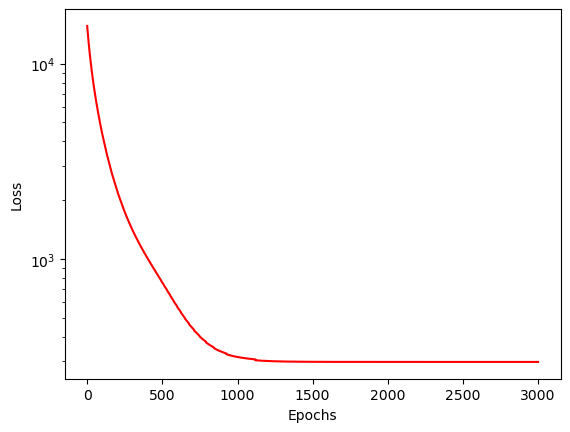

In [275]:
plt.plot(losses,'r')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss');

### Analyze Optimal Solution

In [276]:
state_x, P_x = simulate_keller_dx(init_state, P_func, opt_params, phys_params, dx=dx, L=L)

# unpack state for easier plotting
ts = state_x[:,0]
vs = state_x[:,1]
Es = state_x[:,2]

xs = np.arange(0,L,dx)

T = ts[-1]

print(f'Final time in {int(L)}m:\t{float(T):.2f} s')
print(f'Average speed:\t\t{L/float(T):.2f} m/s')

Final time in 100m:	10.07 s
Average speed:		9.93 m/s


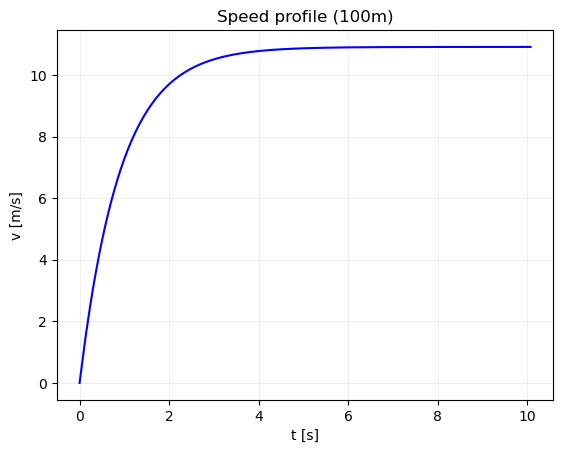

In [277]:
plt.plot(ts, vs, 'b')

plt.xlabel('t [s]')
plt.ylabel('v [m/s]')

plt.title(f'Speed profile ({int(L)}m)')
plt.grid(alpha=.2);

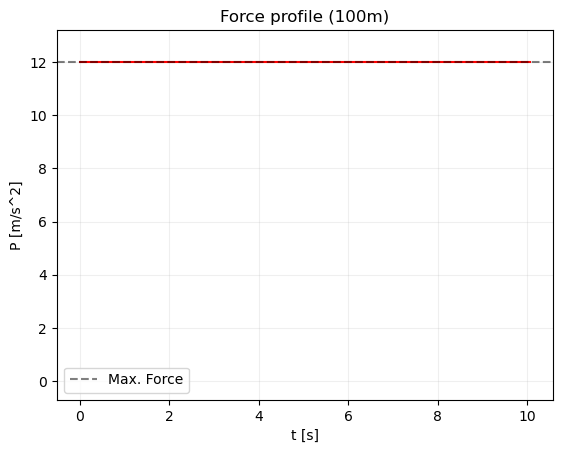

In [278]:
plt.plot(ts, P_x, 'r')

plt.axhline(phys_params.P_max, color='k', linestyle='--', label='Max. Force', alpha=.5)


plt.xlabel('t [s]')
plt.ylabel('P [m/s^2]')
plt.title(f'Force profile ({int(L)}m)')

plt.grid(alpha=.2)

plt.ylim(-.7, phys_params.P_max*1.1)

plt.legend();

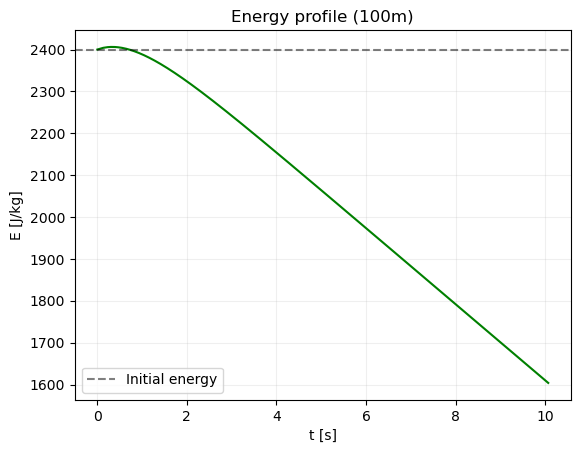

In [279]:
plt.plot(ts, Es, 'g')

plt.axhline(phys_params.E0, color='k', linestyle='--', label='Initial energy', alpha=.5)


plt.xlabel('t [s]')
plt.ylabel('E [J/kg]')
plt.title(f'Energy profile ({int(L)}m)')

plt.grid(alpha=.2)

plt.legend();

**NOTE:** Same solution as Keller's! The small max energy violation at the beginning is due to numerically solving the equations in the space domain instead of the time domain and is in practice irrelevant.